In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance, entropy, norm
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
import sqlite3
from datetime import datetime

In [ ]:
# Load updated datasets
customer_df = pd.read_csv('/content/farmer_advisor_dataset.csv')
market_df = pd.read_csv('/content/market_researcher_dataset.csv')

In [ ]:
# Rename IDs for clarity
customer_df.rename(columns={'ID': 'Farm_ID'}, inplace=True)
market_df.rename(columns={'ID': 'Market_ID'}, inplace=True)

In [ ]:
print("Customer Dataset:")
print(customer_df.head())
print("\nMarket Dataset:")
print(market_df.head())

Customer Dataset:
   Farm_ID   Soil_pH  Soil_Moisture  Temperature_C  Rainfall_mm Crop_Type  \
0        1  7.073643      49.145359      26.668157   227.890912     Wheat   
1        2  6.236931      21.496115      29.325342   244.017493   Soybean   
2        3  5.922335      19.469042      17.666414   141.110521      Corn   
3        4  6.845120      27.974234      17.188722   156.785663     Wheat   
4        5  6.934171      33.637679      23.603899    77.859362      Corn   

   Fertilizer_Usage_kg  Pesticide_Usage_kg  Crop_Yield_ton  \
0           131.692844            2.958215        1.576920   
1           136.370492           19.204770        3.824686   
2            99.725210           11.041066        1.133198   
3           194.832396            8.806271        8.870540   
4            57.271267            3.747553        8.779317   

   Sustainability_Score  
0             51.913649  
1             47.159077  
2             50.148418  
3             89.764557  
4             51

In [ ]:
# Extract unique crops
crop_types = sorted(list(set(customer_df['Crop_Type']).intersection(set(market_df['Product']))))
print("\nCommon Crop Types:", crop_types)


Common Crop Types: ['Corn', 'Rice', 'Soybean', 'Wheat']


Text(0.5, 0, 'Sustainability Score')

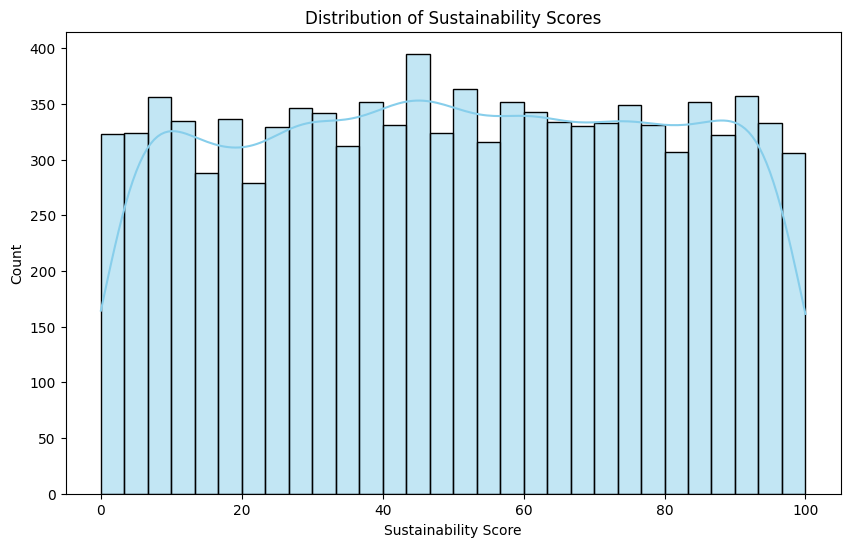

In [ ]:
# Plot histogram of 'Sustainability_Score
plt.figure(figsize=(10, 6))
sns.histplot(customer_df['Sustainability_Score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sustainability Scores')
plt.xlabel('Sustainability Score')

In [ ]:
seasonal_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
market_df['Seasonal_Impact_Num'] = market_df['Seasonal_Factor'].map(seasonal_mapping)

In [ ]:
features = ['Market_Price_per_ton','Demand_Index','Supply_Index','Competitor_Price_per_ton','Economic_Indicator','Weather_Impact_Score','Consumer_Trend_Index','Seasonal_Impact_Num']

In [ ]:
# 📘 Section 2: Define Neural Agent


In [ ]:
class AIRegressor(nn.Module):
    def __init__(self, input_dim):
        super(AIRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# 📘 Section 3: Train Market-based Model to Align with Sustainability Distributions

In [ ]:
results = []
recommendations = []

In [ ]:
# Reference distributions from customer dataset
reference_dist = {}
for crop in crop_types:
    ref_scores = customer_df[customer_df['Crop_Type'] == crop]['Sustainability_Score']
    if len(ref_scores) > 10:
        reference_dist[crop] = (ref_scores.mean(), ref_scores.std())

In [ ]:
# Branch for a new methodology - 5th Idea

In [ ]:
# 2. Prepare global data
X = market_df[features].values
weights = {
    'Market_Price_per_ton': +0.35,
    'Demand_Index': +0.2,
    'Supply_Index': -0.05,               # Higher supply reduces benefit
    'Competitor_Price_per_ton': -0.1,    # Lower competitor price = negative
    'Economic_Indicator': +0.1,
    'Weather_Impact_Score': -0.1,        # Higher score = more weather risk
    'Consumer_Trend_Index': +0.05,
    'Seasonal_Impact_Num': -0.05          # Higher = more seasonal risk
}
y_weighted = np.sum(X * np.array([weights[col] for col in features]), axis=1)
y = y_weighted.reshape(-1, 1)

In [ ]:
market_df['Weighted_Proxy_Score'] = y_weighted
market_df.groupby('Product')[['Weighted_Proxy_Score']].mean().sort_values('Weighted_Proxy_Score', ascending=False)

,Weighted_Proxy_Score
Product,
Rice,94.194529
Corn,93.941109
Soybean,93.024178
Wheat,92.817071


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)

In [ ]:
# 3. Train the global model
model = AIRegressor(input_dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [ ]:
model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 10651.2451171875
Epoch 10, Loss: 10597.041015625
Epoch 20, Loss: 10540.2529296875
Epoch 30, Loss: 10464.0966796875
Epoch 40, Loss: 10360.05859375
Epoch 50, Loss: 10215.6103515625
Epoch 60, Loss: 10022.7255859375
Epoch 70, Loss: 9773.6806640625
Epoch 80, Loss: 9453.7216796875
Epoch 90, Loss: 9054.7841796875
Epoch 100, Loss: 8565.078125
Epoch 110, Loss: 7994.1923828125
Epoch 120, Loss: 7329.46484375
Epoch 130, Loss: 6580.93798828125
Epoch 140, Loss: 5783.67333984375
Epoch 150, Loss: 4928.9755859375
Epoch 160, Loss: 4087.21435546875
Epoch 170, Loss: 3279.26025390625
Epoch 180, Loss: 2552.400146484375
Epoch 190, Loss: 1941.896728515625
Epoch 200, Loss: 1466.2874755859375
Epoch 210, Loss: 1115.397216796875
Epoch 220, Loss: 855.2113647460938
Epoch 230, Loss: 683.52880859375
Epoch 240, Loss: 579.7064208984375
Epoch 250, Loss: 509.0053405761719
Epoch 260, Loss: 468.85546875
Epoch 270, Loss: 435.05401611328125
Epoch 280, Loss: 405.336181640625
Epoch 290, Loss: 387.4708557128906
E

In [ ]:
# 4. Predict for all market data
model.eval()
X_all_scaled = scaler.transform(X)
X_all_tensor = torch.FloatTensor(X_all_scaled)
y_pred = model(X_all_tensor).detach().numpy().flatten()
market_df['Predicted_Score'] = y_pred

In [ ]:
print(market_df['Predicted_Score'].head())

0     67.934151
1    127.112556
2    158.608871
3     95.987495
4     96.506538
Name: Predicted_Score, dtype: float32


In [ ]:
# Reference distributions from farmer data
reference_dist = {}
for crop in customer_df['Crop_Type'].unique():
    ref_scores = customer_df[customer_df['Crop_Type'] == crop]['Sustainability_Score']
    if len(ref_scores) > 10:
        reference_dist[crop] = (ref_scores.mean(), ref_scores.std())

In [ ]:
crop_list = list(reference_dist.keys())
likelihood_matrix = []

In [ ]:
for score in y_pred:
    likelihoods = []
    for crop in crop_list:
        mean, std = reference_dist[crop]
        likelihoods.append(norm.pdf(score, loc=mean, scale=std))
    likelihood_matrix.append(likelihoods)

In [ ]:
likelihood_matrix = np.array(likelihood_matrix)
softmax_matrix = np.exp(likelihood_matrix) / np.sum(np.exp(likelihood_matrix), axis=1, keepdims=True)

In [ ]:
# Attach probabilities to market_df
for i, crop in enumerate(crop_list):
    market_df[f"{crop}_Prob"] = softmax_matrix[:, i]

In [ ]:
market_df['Best_Crop'] = softmax_matrix.argmax(axis=1)
market_df['Best_Crop'] = market_df['Best_Crop'].apply(lambda idx: crop_list[idx])

In [ ]:
top_matches = []
for idx, row in market_df.iterrows():
    best_crop = row['Best_Crop']
    mean, std = reference_dist[best_crop]
    delta = abs(row['Predicted_Score'] - mean)
    prob_score = row[f"{best_crop}_Prob"]

    top_matches.append({
        'Market_ID': row['Market_ID'],
        'Predicted_Score': row['Predicted_Score'],
        'Best_Crop': best_crop,
        'Probability_Score': prob_score,
        'Difference_From_Mean': delta,
        'Fit_Tag': 'Very Close' if delta < 0.2 * std else ('Moderate Fit' if delta < 0.5 * std else 'Distant Fit')
    })

In [ ]:
recommendations_df = pd.DataFrame(top_matches)

In [ ]:
recommendations_df.head()

,Market_ID,Predicted_Score,Best_Crop,Probability_Score,Difference_From_Mean,Fit_Tag
0,1,67.934151,Wheat,0.250033,17.556174,Distant Fit
1,2,127.112556,Corn,0.250012,76.775840,Distant Fit
2,3,158.608871,Corn,0.250001,108.272155,Distant Fit
3,4,95.987495,Corn,0.250035,45.650779,Distant Fit
4,5,96.506538,Corn,0.250035,46.169822,Distant Fit


In [ ]:
# Step 1: Recompute crop_distributions
crop_distributions = {}
for crop in customer_df['Crop_Type'].unique():
    scores = customer_df[customer_df['Crop_Type'] == crop]['Sustainability_Score']
    crop_distributions[crop] = {
        'mean': scores.mean(),
        'std': scores.std()
    }

In [ ]:
print(crop_distributions)

{'Wheat': {'mean': np.float64(50.37797660327763), 'std': 28.317076348799862}, 'Soybean': {'mean': np.float64(50.020930720912034), 'std': 28.372919185121706}, 'Corn': {'mean': np.float64(50.336716110938774), 'std': 29.216600925938273}, 'Rice': {'mean': np.float64(50.12116381792024), 'std': 28.79021287790231}}


In [ ]:
# Step 2: Replace the matching logic with z-score based softmax
def compute_crop_probs(score,crop_distributions, T=0.5):
    likelihoods = []
    for crop in crop_distributions:
        mu = crop_distributions[crop]['mean']
        sigma = crop_distributions[crop]['std']
        z = abs(score - mu) / sigma
        likelihood = np.exp(-z**2)  # sharper but still smooth
        likelihoods.append(likelihood)
    likelihoods = np.array(likelihoods)
    return np.exp(likelihoods / T) / np.sum(np.exp(likelihoods / T))

In [ ]:
# Step 3: Apply across all predicted scores
crop_list = list(crop_distributions.keys())
prob_matrix = np.array([compute_crop_probs(score,crop_distributions) for score in market_df['Predicted_Score']])
prob_df = pd.DataFrame(prob_matrix, columns=[f"{crop}_Prob" for crop in crop_list])

In [ ]:
print(prob_df.head(10))

   Wheat_Prob  Soybean_Prob  Corn_Prob  Rice_Prob
0    0.249172      0.244427   0.256694   0.249706
1    0.249942      0.249929   0.250119   0.250010
2    0.250000      0.250000   0.250000   0.250000
3    0.248188      0.247080   0.254389   0.250342
4    0.248243      0.247191   0.254232   0.250333
5    0.249940      0.249927   0.250122   0.250010
6    0.244546      0.250242   0.252849   0.252363
7    0.249885      0.249857   0.250237   0.250021
8    0.250000      0.250000   0.250000   0.250000
9    0.245806      0.250765   0.251553   0.251876


In [ ]:
# Step 4: Merge and update best crop
market_df = market_df.drop(columns=[col for col in market_df.columns if '_Prob' in col], errors='ignore')
market_df = pd.concat([market_df.reset_index(drop=True), prob_df.reset_index(drop=True)], axis=1)
market_df['Best_Crop'] = prob_df.idxmax(axis=1).str.replace('_Prob', '')

In [ ]:
# Step 5: See new recommendation spread
market_df['Best_Crop'].value_counts()

,count
Best_Crop,
Corn,8925
Rice,529
Soybean,452
Wheat,94


In [ ]:
# --- MATCH CUSTOMER TO BEST-FIT MARKET ROW ---
customer_recommendations = []

for _, row in customer_df.iterrows():
    customer_id = row['Farm_ID'] if 'Farm_ID' in row else row['ID']

    customer_features = row[['Soil_pH', 'Soil_Moisture','Temperature_C','Rainfall_mm','Fertilizer_Usage_kg','Pesticide_Usage_kg','Crop_Yield_ton']]  # Adjust if more
    customer_score = customer_features.mean()         # Proxy matching score

    closest_row = market_df.iloc[(market_df['Predicted_Score'] - customer_score).abs().argsort()[:1]].iloc[0]

    best_crop = closest_row['Best_Crop']
    best_prob = closest_row[f"{best_crop}_Prob"]
    mean, std = reference_dist[best_crop]
    delta = abs(closest_row['Predicted_Score'] - mean)
    fit_tag = 'Very Close' if delta < 0.2 * std else ('Moderate Fit' if delta < 0.5 * std else 'Distant Fit')

    customer_recommendations.append({
        'Customer_ID': customer_id,
        'Present_crop': row['Crop_Type'],
        'Customer_Proxy_Score': customer_score,
        'Closest_Market_ID': closest_row['Market_ID'],
        'Predicted_Score': closest_row['Predicted_Score'],
        'Best_Crop': best_crop,
        'Probability_Score': best_prob,
        'Difference_From_Mean': delta,
        'Fit_Tag': fit_tag
    })

In [ ]:
customer_recommendations_df = pd.DataFrame(customer_recommendations)

In [ ]:
customer_recommendations_df.head()

,Customer_ID,Present_crop,Customer_Proxy_Score,Closest_Market_ID,Predicted_Score,Best_Crop,Probability_Score,Difference_From_Mean,Fit_Tag
0,1,Wheat,63.858007,2822,63.849995,Corn,0.254980,13.513279,Moderate Fit
1,2,Soybean,65.782261,6184,65.785698,Corn,0.255833,15.448982,Distant Fit
2,3,Corn,42.295398,9976,42.300419,Rice,0.251121,7.820745,Moderate Fit
3,4,Wheat,60.186135,6951,60.199711,Corn,0.253301,9.862995,Moderate Fit
4,5,Corn,30.261893,8546,30.263386,Corn,0.253779,20.073330,Distant Fit


In [ ]:
customer_recommendations_df['Best_Crop'].value_counts()

,count
Best_Crop,
Corn,6355
Soybean,1821
Rice,1455
Wheat,369


In [ ]:
customer_df.groupby("Crop_Type")[['Crop_Yield_ton', 'Fertilizer_Usage_kg','Pesticide_Usage_kg', 'Sustainability_Score']].mean()

,Crop_Yield_ton,Fertilizer_Usage_kg,Pesticide_Usage_kg,Sustainability_Score
Crop_Type,,,,
Corn,5.532548,125.970626,10.315976,50.336716
Rice,5.530344,125.225328,10.574321,50.121164
Soybean,5.469330,124.207422,10.538798,50.020931
Wheat,5.428687,125.482601,10.650718,50.377977


In [ ]:
for score in np.random.choice(market_df['Predicted_Score'], 5):  # pick random scores
    z_scores = [(crop, abs(score - d['mean']) / d['std']) for crop, d in crop_distributions.items()]
    z_scores.sort(key=lambda x: x[1])
    print(f"\nScore: {score:.2f}")
    for crop, z in z_scores:
        print(f"  {crop}: z={z:.2f}")


Score: 152.22
  Corn: z=3.49
  Rice: z=3.55
  Wheat: z=3.60
  Soybean: z=3.60

Score: 115.20
  Corn: z=2.22
  Rice: z=2.26
  Wheat: z=2.29
  Soybean: z=2.30

Score: 29.19
  Corn: z=0.72
  Rice: z=0.73
  Soybean: z=0.73
  Wheat: z=0.75

Score: 123.60
  Corn: z=2.51
  Rice: z=2.55
  Wheat: z=2.59
  Soybean: z=2.59

Score: 51.11
  Wheat: z=0.03
  Corn: z=0.03
  Rice: z=0.03
  Soybean: z=0.04


<Axes: title={'center': 'Crop Recommendation Proportions'}, xlabel='Best_Crop'>

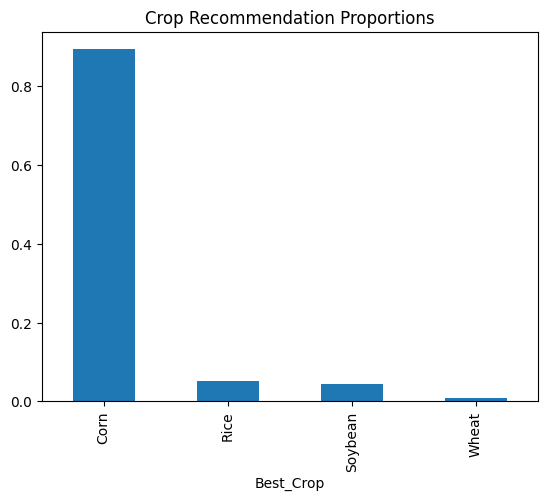

In [ ]:
market_df['Best_Crop'].value_counts(normalize=True).plot(kind='bar', title='Crop Recommendation Proportions')

Wheat: mean=50.38, std=28.32
Soybean: mean=50.02, std=28.37
Corn: mean=50.34, std=29.22
Rice: mean=50.12, std=28.79


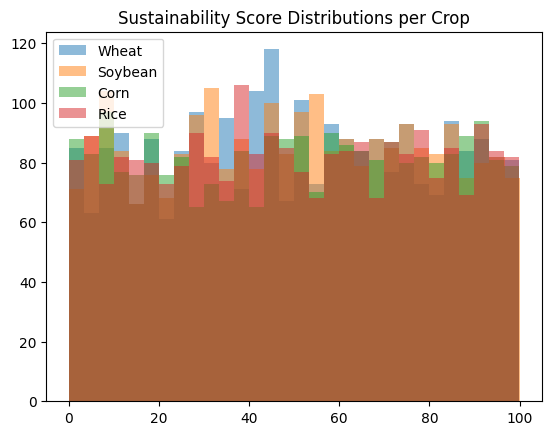

In [ ]:
for crop, stats in crop_distributions.items():
    print(f"{crop}: mean={stats['mean']:.2f}, std={stats['std']:.2f}")

for crop in crop_distributions:
    scores = customer_df[customer_df['Crop_Type'] == crop]['Sustainability_Score']
    plt.hist(scores, bins=30, alpha=0.5, label=crop)
plt.legend()
plt.title("Sustainability Score Distributions per Crop")
plt.show()

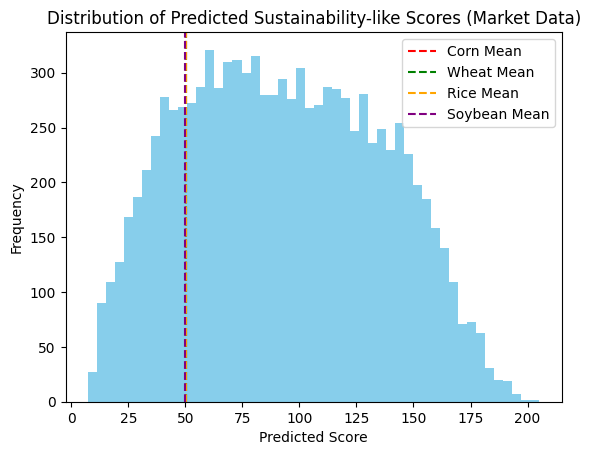

In [ ]:
plt.hist(market_df['Predicted_Score'], bins=50, color='skyblue')
plt.axvline(50.34, color='red', linestyle='--', label='Corn Mean')
plt.axvline(50.38, color='green', linestyle='--', label='Wheat Mean')
plt.axvline(50.12, color='orange', linestyle='--', label='Rice Mean')
plt.axvline(50.02, color='purple', linestyle='--', label='Soybean Mean')
plt.title("Distribution of Predicted Sustainability-like Scores (Market Data)")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
# 🔹 PART A: Smart Input + Model Recommendation
input_ranges = {}
for col in features:
    input_ranges[col] = (round(market_df[col].min(), 2), round(market_df[col].max(), 2))

In [ ]:
print("🌾 Please enter the following values based on your farm/market situation:")
user_input = {}
for col in features:
    min_val, max_val = input_ranges[col]
    user_input[col] = float(input(f"{col} [{min_val} - {max_val}]: "))

🌾 Please enter the following values based on your farm/market situation:
Market_Price_per_ton [100.04 - 500.0]: 250
Demand_Index [50.03 - 200.0]: 120
Supply_Index [50.02 - 199.99]: 60
Competitor_Price_per_ton [100.06 - 499.92]: 250
Economic_Indicator [0.5 - 1.5]: 1
Weather_Impact_Score [0.04 - 100.0]: 10
Consumer_Trend_Index [50.01 - 150.0]: 100
Seasonal_Impact_Num [1 - 3]: 2


In [ ]:
X_input = np.array([[user_input[col] for col in features]])
X_tensor = torch.FloatTensor(X_input)
model.eval()
predicted_score = model(X_tensor).item()

In [ ]:
def compute_probs(score):
    likelihoods = []
    for crop in crop_distributions:
        mu, sigma = crop_distributions[crop]['mean'], crop_distributions[crop]['std']
        z = abs(score - mu) / sigma
        likelihood = np.exp(-z**2)
        likelihoods.append(likelihood)
    likelihoods = np.array(likelihoods)
    return np.exp(likelihoods / 0.5) / np.sum(np.exp(likelihoods / 0.5))

In [ ]:
probs = compute_probs(predicted_score)
crop_list = list(crop_distributions.keys())
best_idx = np.argmax(probs)
best_crop = crop_list[best_idx]
prob_score = probs[best_idx]
mean, std = crop_distributions[best_crop]['mean'], crop_distributions[best_crop]['std']
delta = abs(predicted_score - mean)
fit_tag = "Very Close" if delta < 0.2 * std else ("Moderate Fit" if delta < 0.5 * std else "Distant Fit")

In [ ]:
import openai
from openai import OpenAI

In [ ]:
client = OpenAI(api_key="")

In [ ]:
# 🔹 PART B: Log to SQLite
conn = sqlite3.connect("resilient_crop_advisor.db")
cursor = conn.cursor()
cursor.execute('''
CREATE TABLE IF NOT EXISTS recommendations_log (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    timestamp TEXT,
    user_inputs TEXT,
    predicted_score REAL,
    best_crop TEXT,
    probability_score REAL,
    fit_tag TEXT,
    gpt_recommendation TEXT
)
''')

In [ ]:
# 🔹 PART C: GPT Explanation (Low Temperature for optimal advice)
gpt_prompt = f"""
You are an agriculture expert. A farmer provides the following market condition inputs:
{user_input}
The model predicts a suitability score of {round(predicted_score, 2)}.
The recommended crop is: {best_crop} with a fit assessment of: {fit_tag}.

Please explain why this crop is suitable, potential risks, and how the farmer can maximize sustainability and market value.
"""
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are an expert agri-advisor AI."},
        {"role": "user", "content": gpt_prompt}
    ],
    temperature=0.2
)
# response.choices[0].message.content
gpt_output = response.choices[0].message.content.strip()

# Save in database
cursor.execute('''
INSERT INTO recommendations_log
(timestamp, user_inputs, predicted_score, best_crop, probability_score, fit_tag, gpt_recommendation)
VALUES (?, ?, ?, ?, ?, ?, ?)
''', (
    datetime.now().isoformat(),
    str(user_input),
    predicted_score,
    best_crop,
    prob_score,
    fit_tag,
    gpt_output
))
conn.commit()
conn.close()

In [ ]:
# 🔍 Display results
print("\n✅ Final Recommendation Summary")
print(f"Crop: {best_crop} | Score: {round(predicted_score, 2)} | Fit: {fit_tag} | Probability: {round(prob_score, 4)}")
print("\n🧠 GPT Expert Commentary:\n")
print(gpt_output)


✅ Final Recommendation Summary
Crop: Wheat | Score: 10190.59 | Fit: Distant Fit | Probability: 0.25

🧠 GPT Expert Commentary:

Based on the provided market conditions and the suitability score, let's break down why wheat is recommended, the potential risks involved, and strategies to maximize sustainability and market value.

### Suitability of Wheat:

1. **Market Price and Competitor Price**: The market price per ton for wheat is equal to the competitor price, indicating a stable competitive environment. This suggests that wheat can be sold at a competitive rate without undercutting or overpricing.

2. **Demand and Supply Index**: A Demand Index of 120.0 and a Supply Index of 60.0 suggest that demand significantly exceeds supply. This imbalance is favorable for wheat producers, as it indicates a potential for higher sales and possibly better pricing.

3. **Economic Indicator**: An Economic Indicator of 1.0 suggests a stable economic environment, which is generally favorable for agric

In [ ]:
# Reading the .db file
conn = sqlite3.connect("/content/resilient_crop_advisor.db")
sql_df = pd.read_sql_query("SELECT * FROM recommendations_log", conn)
conn.close()
sql_df.head()

,id,timestamp,user_inputs,predicted_score,best_crop,probability_score,fit_tag,gpt_recommendation
0,1,2025-04-09T10:03:54.968423,"{'Market_Price_per_ton': 250.0, 'Demand_Index'...",10190.585938,Wheat,0.25,Distant Fit,Based on the provided market conditions and th...
1,2,2025-04-09T10:33:28.349136,"{'Market_Price_per_ton': 300.01836411836416, '...",11631.562500,Wheat,0.25,Distant Fit,Based on the provided market conditions and th...
2,3,2025-04-09T10:37:28.327729,"{'Market_Price_per_ton': 220.02609, 'Demand_In...",9622.441406,Wheat,0.25,Distant Fit,Based on the provided market conditions and th...


In [ ]:
!pip install ipywidgets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.5 MB/s eta 0:00:00
